In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet

In [2]:
# carregar raw data
data = pd.read_csv('/kaggle/input/tempcuritiba/temp-curitiba-2012.csv', index_col='date', parse_dates=['date'])
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1886 entries, 2012-10-01 to 2017-11-29
Data columns (total 1 columns):
temperature    1885 non-null float64
dtypes: float64(1)
memory usage: 29.5 KB


,temperature
date,
2012-10-01,11.036840
2012-10-02,14.340558
2012-10-03,14.518382
2012-10-04,16.820351
2012-10-05,16.948431


In [3]:
# ajustar dados de treino para o formato do Prophet
data2 = data[['temperature']]
data2 = data2.reset_index()
data2.columns = ['ds', 'y']
data2.head()

,ds,y
0,2012-10-01,11.036840
1,2012-10-02,14.340558
2,2012-10-03,14.518382
3,2012-10-04,16.820351
4,2012-10-05,16.948431


In [4]:
# dividir os dados em 80% + 20%
divisao = int(data2.shape[0] * 4 / 5)
data2a = data2[:divisao]
data2b = data2[divisao:]
print(data2.shape, '=', data2a.shape, '+', data2b.shape)
data2a.info()
data2a.head()

(1886, 2) = (1508, 2) + (378, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1508 entries, 0 to 1507
Data columns (total 2 columns):
ds    1508 non-null datetime64[ns]
y     1507 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 23.7 KB


,ds,y
0,2012-10-01,11.036840
1,2012-10-02,14.340558
2,2012-10-03,14.518382
3,2012-10-04,16.820351
4,2012-10-05,16.948431


In [5]:
# criar e treinar o modelo
model = Prophet(daily_seasonality=False)
model.fit(data2a)

In [6]:
# preparar dados futuros
future = data2b.drop(['y'], axis=1)
future.info()
future.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 1508 to 1885
Data columns (total 1 columns):
ds    378 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 3.1 KB


,ds
1508,2016-11-17
1509,2016-11-18
1510,2016-11-19
1511,2016-11-20
1512,2016-11-21


In [7]:
# realizar a previsão
forecast = model.predict(future)
forecast[['ds', 'yhat']].tail()

,ds,yhat
373,2017-11-25,15.880065
374,2017-11-26,15.571608
375,2017-11-27,15.736231
376,2017-11-28,15.694693
377,2017-11-29,15.299645


In [8]:
# mesclar os dois dataframes novamente
data3 = data2b.merge(forecast)[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']]
data3['diff'] = abs(data3['y'] - data3['yhat'])
data3.info()
data3.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378 entries, 0 to 377
Data columns (total 6 columns):
ds            378 non-null datetime64[ns]
y             378 non-null float64
yhat          378 non-null float64
yhat_lower    378 non-null float64
yhat_upper    378 non-null float64
diff          378 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 20.7 KB


,ds,y,yhat,yhat_lower,yhat_upper,diff
0,2016-11-17,13.760203,13.596638,7.614891,18.953353,0.163564
1,2016-11-18,21.451060,13.441861,7.598186,19.195553,8.009199
2,2016-11-19,13.059696,13.358999,7.663264,19.050003,0.299303
3,2016-11-20,8.178332,12.935669,7.314016,18.781684,4.757337
4,2016-11-21,6.044745,12.974483,7.427909,18.508050,6.929738


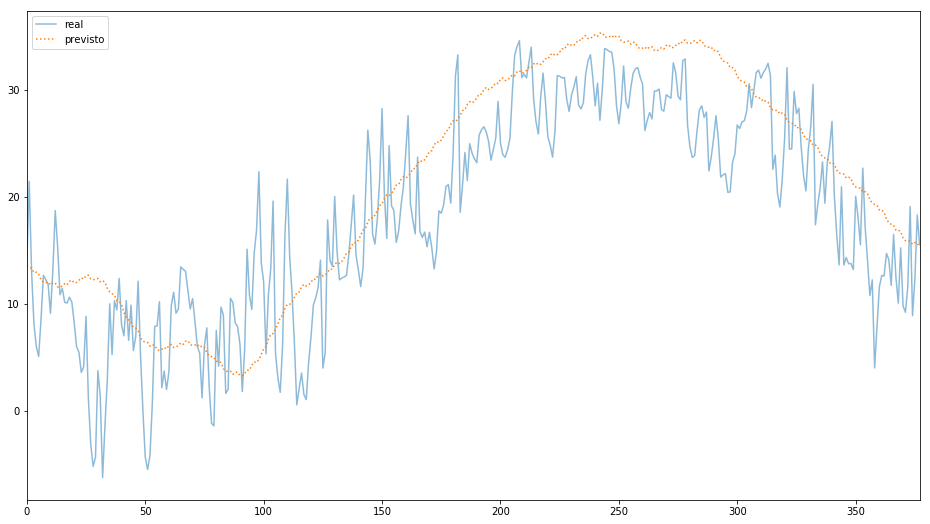

In [9]:
# plotar gráfico comparando valores reais e previstos
plt.figure(figsize=(16, 9))

data3['y'].plot(alpha=0.5, style='-')
data3['yhat'].plot(style=':')
#data3['yhat_lower'].plot(style='--')
#data3['yhat_upper'].plot(style='--')
#plt.legend(['real', 'previsto', 'pmenor', 'pmaior'], loc='upper left')
plt.legend(['real', 'previsto'], loc='upper left')

In [10]:
def rmse(predictions, targets):
    assert len(predictions) == len(targets)
    return np.sqrt(np.mean((predictions - targets) ** 2))

def rmsle(predictions, targets):
    assert len(predictions) == len(targets)
    return np.sqrt(np.mean((np.log(1 + predictions) - np.log(1 + targets)) ** 2))

In [11]:
print('RMSE:', rmse(data3['yhat'], data3['y']))

RMSE: 5.8789896415560055


In [12]:
# criar e treinar o modelo
model = Prophet(daily_seasonality=False)
model.fit(data2)

In [13]:
# criar série com dados futuros (2 anos)
future = model.make_future_dataframe(periods=365*2)
future.tail()

,ds
2611,2019-11-25
2612,2019-11-26
2613,2019-11-27
2614,2019-11-28
2615,2019-11-29


In [14]:
# realizar previsão com dados futuros
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2611,2019-11-25,13.680343,7.164286,19.713957
2612,2019-11-26,13.671257,7.848903,19.947006
2613,2019-11-27,13.180165,7.247737,19.617871
2614,2019-11-28,12.927399,6.635663,19.044428
2615,2019-11-29,12.739513,6.732635,18.683609


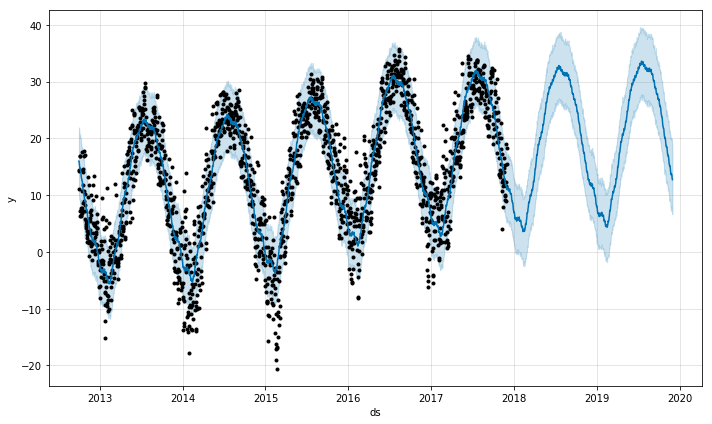

In [15]:
pd.plotting.register_matplotlib_converters() #https://github.com/facebook/prophet/issues/1101

# gráfico dados seguindo de previsão
fig1 = model.plot(forecast)

Uma propriedade dessa maneira de medir a incerteza é que permitir maior flexibilidade na taxa, aumentando changepoint_prior_scale, aumentará a incerteza da previsão. Isso ocorre porque, se modelarmos mais mudanças de taxa no histórico, esperamos mais no futuro e torna os intervalos de incerteza um indicador útil de overfitting.

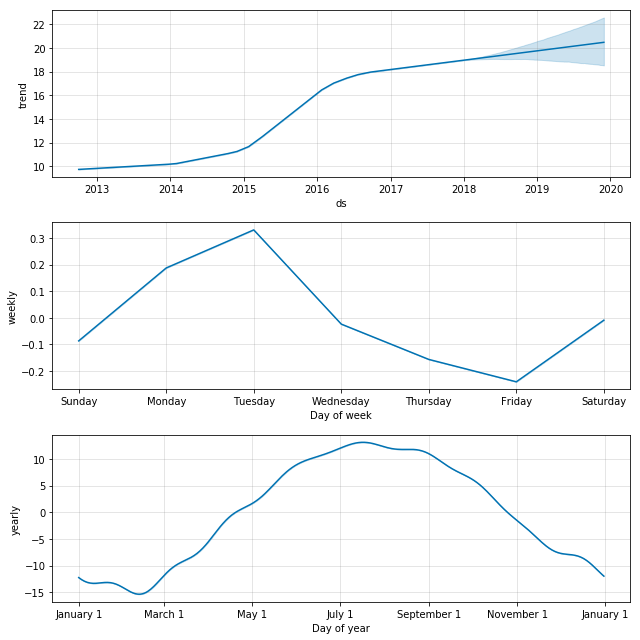

In [16]:
# tendência, sazonalidade anual e sazonalidade semanal da série temporal.
fig2 = model.plot_components(forecast)